In [1]:
"""
Multi-step ahead forecasting
Forecasting n_ahead steps all at once using WaveNet
"""

#Imports
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

In [2]:
#Load Data
data = pd.read_csv('data/AEP_hourly.csv', index_col=0, parse_dates=True)

#Sort the dataframe
data.sort_values('Datetime', inplace=True)

#scale the timeseries using standard scaler
ts = np.asarray(data['AEP_MW']).reshape(-1,1)
scaler = preprocessing.StandardScaler().fit(ts)
ts_scaled = list(scaler.transform(ts))

In [3]:
#create 3D array of timeseries of fixed length
n_ahead = 24
n_lag = n_ahead*20

max_idx = int(np.floor(len(ts_scaled) / (n_lag + n_ahead)))

i=0
series = []
for i in range(0, max_idx):
    n = n_lag + n_ahead
    series.append(ts_scaled[i*n : (i+1) * n])

#create training matrix and target vector
X = np.asarray(series)[:,0:n_lag,:]
y_plot = np.asarray(series)[:,n_lag:,:].squeeze()
y = np.empty((np.shape(X)[0], np.shape(X)[1], n_ahead))


for i in range(1, n_ahead+1):
    y[:,:,i-1] = np.asarray(series)[:,i:i+n_lag,0]

In [4]:
#create training, validation, and testing sets
train_valid_test = [0.7,0.2,0.1]
train_valid_test_idx = np.floor(np.asarray(train_valid_test) * max_idx).astype(int)
X_train, y_train = X[0:train_valid_test_idx[0],:,:], y[0:train_valid_test_idx[0],:,:]
X_valid, y_valid = X[0:train_valid_test_idx[1],:,:], y[0:train_valid_test_idx[1],:,:]
X_test, y_test = X[0:train_valid_test_idx[2],:,:], y[0:train_valid_test_idx[2],:,:]

In [19]:
#WaveNet

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None,1]))
for rate in (1,2,4,8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding='causal',
                                    activation='relu', dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=n_ahead, kernel_size=1))

#custom loss function
def last_timestep_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:,-1], Y_pred[:,-1])

#compile model
lr = 0.01
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss='mse', metrics=[last_timestep_mse])

epochs = 50

#create a dict for keras training args
keras_dict = {
    'x':X_train,
    'y':y_train,
    'epochs':epochs,
    'shuffle':False,
    'validation_data':(X_valid,y_valid)
}

#fit the model
history = model.fit(**keras_dict)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
6/6 [==============================] - 0s 62ms/step - loss: 0.9948 - last_timestep_mse: 1.0769 - val_loss: 0.8876 - val_last_timestep_mse: 1.0016
Epoch 2/50
6/6 [==============================] - 0s 33ms/step - loss: 0.8730 - last_timestep_mse: 0.9573 - val_loss: 0.6861 - val_last_timestep_mse: 0.6580
Epoch 3/50
6/6 [==============================] - 0s 32ms/step - loss: 0.6339 - last_t

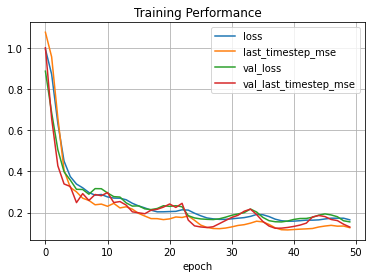

In [20]:
#Plot Training Results
hist_df = pd.DataFrame(history.history)
hist_df.plot()
plt.grid(True)
plt.title('Training Performance')
plt.xlabel('epoch')
plt.show()

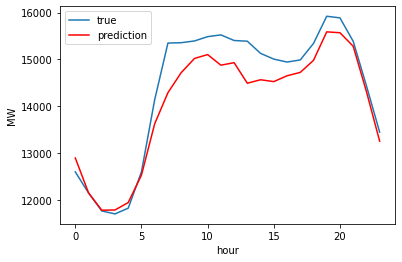

In [21]:
#predict
y_pred = model.predict((X_test[0])[np.newaxis,...])

#Inverse transform scaled data
y_true = scaler.inverse_transform(y_test[0,-1].reshape(-1,1))
y_pred = scaler.inverse_transform(y_pred.squeeze()[-1,:].reshape(-1,1))

plt.plot(y_true,label='true')
plt.plot(y_pred,'r',label='prediction')
plt.legend()
plt.xlabel('hour')
plt.ylabel('MW')
plt.show()